### Limma voom analysis of AD/PD dataset, NO SVA, ON PSEUDOREPS 

In [1]:
rm(list=ls())
#load necessary libraries 
library(ggplot2)
library(DESeq2)
library("BiocParallel")
parallelFlag=TRUE
register(MulticoreParam(50))
library("IHW")
library("pheatmap")
library(sva)
library(limma)

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsplit, which, which.max, which

## Load data and design

In [4]:
##load ATAC-seq raw read counts
data=read.table('../pseudorep_check/pr.adpd.atac.idr.counts.txt.gz',header=TRUE,sep='\t')

##concatenate chrom/start/end columns values to server as rownames for the dataframe of the form chrom_start_end 
rownames(data)=paste(data$chrom,data$start,data$end,sep="_")
data$chrom=NULL
data$start=NULL
data$end=NULL

data=data[rowSums(data)>0,]


In [24]:
ncol(data)

[1] 411

In [3]:
#load ATAC-seq data normalized counts. These were generated below w/ voom function 
#E=read.table("pr.idr.voom.qnorm.txt",header=TRUE,sep='\t',row.names=1)

In [6]:
#load the metadata
batches=read.table("../pseudorep_check/pr.batches.txt",header=TRUE,sep='\t')

In [7]:
head(batches)

Sample,Cohort,Type,Region
<fct>,<fct>,<fct>,<fct>
AD_ADAD_CAUD.0,AD,ADAD,CAUD
AD_ADAD_CAUD.10,AD,ADAD,CAUD
AD_ADAD_CAUD.11,AD,ADAD,CAUD
AD_ADAD_CAUD.12,AD,ADAD,CAUD
AD_ADAD_CAUD.13,AD,ADAD,CAUD
AD_ADAD_CAUD.14,AD,ADAD,CAUD


## Normalize the data with Limma  

In [8]:
tpm=voom(data,normalize.method = "quantile")
E=tpm$E
E=round(E,2)

In [9]:
#save the normalized data so we can load those values directly next time
write.table(E,file="pr.idr.voom.qnorm.txt",quote=FALSE,sep='\t')

## Perform PCA analysis find which covariates account for axes of variation

In [10]:
data.pca=prcomp(t(E))

In [11]:
var_explained=as.character(round(100*data.pca$sdev^2/sum(data.pca$sdev^2),2))


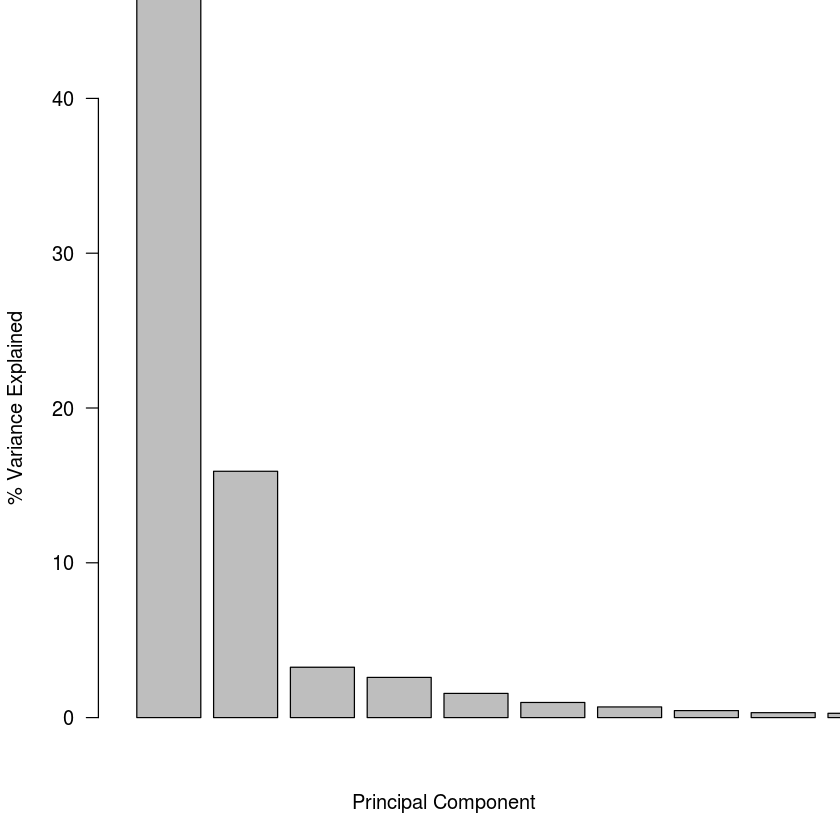

In [12]:
barplot(100*data.pca$sdev^2/sum(data.pca$sdev^2),las=2,ylab="% Variance Explained",xlab="Principal Component",ylim=c(0,40), xlim=c(0,10))

In [13]:
var_explained[0:10]

[1] "46.78" "15.91" "3.25"  "2.6"   "1.56"  "0.98"  "0.69"  "0.45"  "0.32" 
[10] "0.28"

In [26]:
nrow(batches)

[1] 411

In [14]:
pca_df=data.frame(data.pca$x)
pca_df=cbind(pca_df,batches)

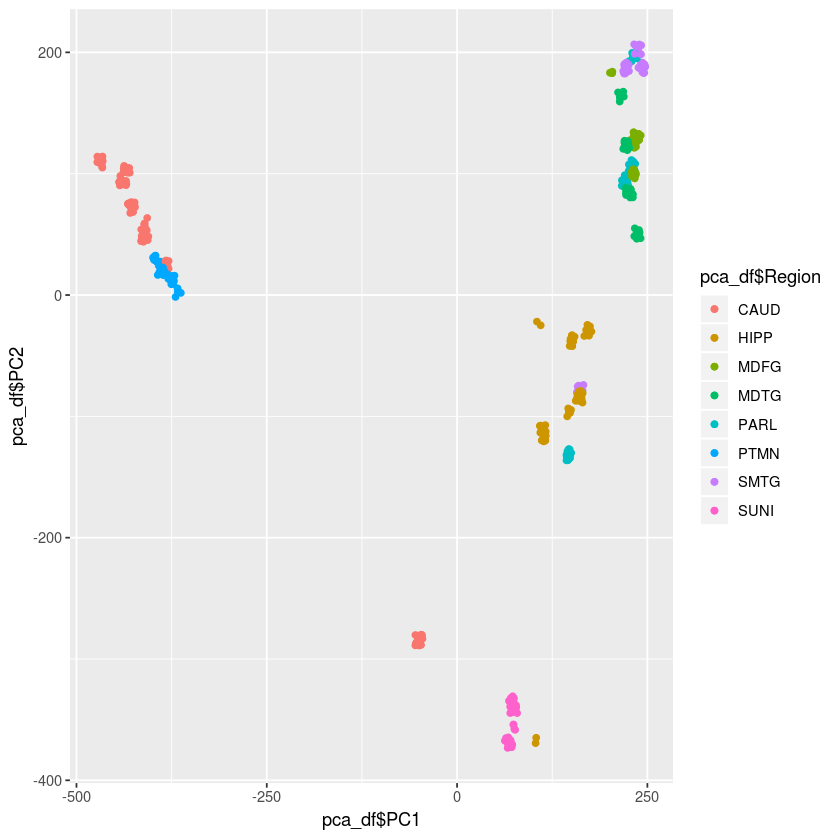

In [49]:
ggplot(data=pca_df,aes(x=pca_df$PC1,y=pca_df$PC2,color=pca_df$Region))+
geom_point(position='jitter')+
geom_jitter(width = 5, height = 5)

## Grouping on Cohort, Region, and Type

In [16]:
Grouping <- factor(paste0(batches$Cohort,".",batches$Region, ".", batches$Type))

In [17]:
batches$Grouping=Grouping

In [18]:
colSums(is.na(batches))

Sample   Cohort     Type   Region Grouping 
       0        0        0        0        0

In [19]:
mod=model.matrix(~Grouping,data=batches)

### fit model with limma 

In [20]:
fit <- lmFit(E,mod)

In [21]:
colnames(mod)


[1] "(Intercept)"          "GroupingAD.CAUD.CTRH" "GroupingAD.CAUD.CTRL"
 [4] "GroupingAD.CAUD.LOAD" "GroupingAD.HIPP.ADAD" "GroupingAD.HIPP.CTRH"
 [7] "GroupingAD.HIPP.CTRL" "GroupingAD.HIPP.LOAD" "GroupingAD.PARL.ADAD"
[10] "GroupingAD.PARL.CTRH" "GroupingAD.PARL.CTRL" "GroupingAD.PARL.LOAD"
[13] "GroupingAD.SMTG.ADAD" "GroupingAD.SMTG.CTRH" "GroupingAD.SMTG.CTRL"
[16] "GroupingAD.SMTG.LOAD" "GroupingPD.CAUD.CTRL" "GroupingPD.CAUD.GBA1"
[19] "GroupingPD.CAUD.LOPD" "GroupingPD.CAUD.LRRK" "GroupingPD.HIPP.CTRL"
[22] "GroupingPD.HIPP.GBA1" "GroupingPD.HIPP.LOPD" "GroupingPD.HIPP.LRRK"
[25] "GroupingPD.MDFG.CTRL" "GroupingPD.MDFG.GBA1" "GroupingPD.MDFG.LOPD"
[28] "GroupingPD.MDFG.LRRK" "GroupingPD.MDTG.CTRL" "GroupingPD.MDTG.GBA1"
[31] "GroupingPD.MDTG.LOPD" "GroupingPD.MDTG.LRRK" "GroupingPD.PTMN.CTRL"
[34] "GroupingPD.PTMN.GBA1" "GroupingPD.PTMN.LOPD" "GroupingPD.PTMN.LRRK"
[37] "GroupingPD.SUNI.CTRL" "GroupingPD.SUNI.GBA1" "GroupingPD.SUNI.LOPD"
[40] "GroupingPD.SUNI.LRRK"

In [22]:
colnames(fit$coefficients)

[1] "(Intercept)"          "GroupingAD.CAUD.CTRH" "GroupingAD.CAUD.CTRL"
 [4] "GroupingAD.CAUD.LOAD" "GroupingAD.HIPP.ADAD" "GroupingAD.HIPP.CTRH"
 [7] "GroupingAD.HIPP.CTRL" "GroupingAD.HIPP.LOAD" "GroupingAD.PARL.ADAD"
[10] "GroupingAD.PARL.CTRH" "GroupingAD.PARL.CTRL" "GroupingAD.PARL.LOAD"
[13] "GroupingAD.SMTG.ADAD" "GroupingAD.SMTG.CTRH" "GroupingAD.SMTG.CTRL"
[16] "GroupingAD.SMTG.LOAD" "GroupingPD.CAUD.CTRL" "GroupingPD.CAUD.GBA1"
[19] "GroupingPD.CAUD.LOPD" "GroupingPD.CAUD.LRRK" "GroupingPD.HIPP.CTRL"
[22] "GroupingPD.HIPP.GBA1" "GroupingPD.HIPP.LOPD" "GroupingPD.HIPP.LRRK"
[25] "GroupingPD.MDFG.CTRL" "GroupingPD.MDFG.GBA1" "GroupingPD.MDFG.LOPD"
[28] "GroupingPD.MDFG.LRRK" "GroupingPD.MDTG.CTRL" "GroupingPD.MDTG.GBA1"
[31] "GroupingPD.MDTG.LOPD" "GroupingPD.MDTG.LRRK" "GroupingPD.PTMN.CTRL"
[34] "GroupingPD.PTMN.GBA1" "GroupingPD.PTMN.LOPD" "GroupingPD.PTMN.LRRK"
[37] "GroupingPD.SUNI.CTRL" "GroupingPD.SUNI.GBA1" "GroupingPD.SUNI.LOPD"
[40] "GroupingPD.SUNI.LRRK"

###  Contrasts 

In [55]:
#create contrasts of interest 
cont.matrix=makeContrasts(
    pd_caud_gba1_vs_lrrk="GroupingPD.CAUD.GBA1 - GroupingPD.CAUD.LRRK",
    pd_caud_gba1_vs_lopd="GroupingPD.CAUD.GBA1 - GroupingPD.CAUD.LOPD",
    pd_caud_gba1_vs_ctrl="GroupingPD.CAUD.GBA1 - GroupingPD.CAUD.CTRL",
    pd_caud_lrrk_vs_lopd="GroupingPD.CAUD.LRRK - GroupingPD.CAUD.LOPD",
    pd_caud_lrrk_vs_ctrl="GroupingPD.CAUD.LRRK - GroupingPD.CAUD.CTRL",
    pd_caud_lopd_vs_ctrl="GroupingPD.CAUD.LOPD - GroupingPD.CAUD.CTRL",
    pd_hipp_gba1_vs_lrrk="GroupingPD.HIPP.GBA1 - GroupingPD.HIPP.LRRK",
    pd_hipp_gba1_vs_lopd="GroupingPD.HIPP.GBA1 - GroupingPD.HIPP.LOPD",
    pd_hipp_gba1_vs_ctrl="GroupingPD.HIPP.GBA1 - GroupingPD.HIPP.CTRL",
    pd_hipp_lrrk_vs_lopd="GroupingPD.HIPP.LRRK - GroupingPD.HIPP.LOPD",
    pd_hipp_lrrk_vs_ctrl="GroupingPD.HIPP.LRRK - GroupingPD.HIPP.CTRL",
    pd_hipp_lopd_vs_ctrl="GroupingPD.HIPP.LOPD - GroupingPD.HIPP.CTRL",
    pd_mdfg_gba1_vs_lrrk="GroupingPD.MDFG.GBA1 - GroupingPD.MDFG.LRRK",
    pd_mdfg_gba1_vs_lopd="GroupingPD.MDFG.GBA1 - GroupingPD.MDFG.LOPD",
    pd_mdfg_gba1_vs_ctrl="GroupingPD.MDFG.GBA1 - GroupingPD.MDFG.CTRL",
    pd_mdfg_lrrk_vs_lopd="GroupingPD.MDFG.LRRK - GroupingPD.MDFG.LOPD",
    pd_mdfg_lrrk_vs_ctrl="GroupingPD.MDFG.LRRK - GroupingPD.MDFG.CTRL",
    pd_mdfg_lopd_vs_ctrl="GroupingPD.MDFG.LOPD - GroupingPD.MDFG.CTRL",
    pd_mdtg_gba1_vs_lrrk="GroupingPD.MDTG.GBA1 - GroupingPD.MDTG.LRRK",
    pd_mdtg_gba1_vs_lopd="GroupingPD.MDTG.GBA1 - GroupingPD.MDTG.LOPD",
    pd_mdtg_gba1_vs_ctrl="GroupingPD.MDTG.GBA1 - GroupingPD.MDTG.CTRL",
    pd_mdtg_lrrk_vs_lopd="GroupingPD.MDTG.LRRK - GroupingPD.MDTG.LOPD",
    pd_mdtg_lrrk_vs_ctrl="GroupingPD.MDTG.LRRK - GroupingPD.MDTG.CTRL",
    pd_mdtg_lopd_vs_ctrl="GroupingPD.MDTG.LOPD - GroupingPD.MDTG.CTRL",
    pd_ptmn_gba1_vs_lrrk="GroupingPD.PTMN.GBA1 - GroupingPD.PTMN.LRRK",
    pd_ptmn_gba1_vs_lopd="GroupingPD.PTMN.GBA1 - GroupingPD.PTMN.LOPD",
    pd_ptmn_gba1_vs_ctrl="GroupingPD.PTMN.GBA1 - GroupingPD.PTMN.CTRL",
    pd_ptmn_lrrk_vs_lopd="GroupingPD.PTMN.LRRK - GroupingPD.PTMN.LOPD",
    pd_ptmn_lrrk_vs_ctrl="GroupingPD.PTMN.LRRK - GroupingPD.PTMN.CTRL",
    pd_ptmn_lopd_vs_ctrl="GroupingPD.PTMN.LOPD - GroupingPD.PTMN.CTRL",
    pd_suni_gba1_vs_lrrk="GroupingPD.SUNI.GBA1 - GroupingPD.SUNI.LRRK",
    pd_suni_gba1_vs_lopd="GroupingPD.SUNI.GBA1 - GroupingPD.SUNI.LOPD",
    pd_suni_gba1_vs_ctrl="GroupingPD.SUNI.GBA1 - GroupingPD.SUNI.CTRL",
    pd_suni_lrrk_vs_lopd="GroupingPD.SUNI.LRRK - GroupingPD.SUNI.LOPD",
    pd_suni_lrrk_vs_ctrl="GroupingPD.SUNI.LRRK - GroupingPD.SUNI.CTRL",
    pd_suni_lopd_vs_ctrl="GroupingPD.SUNI.LOPD - GroupingPD.SUNI.CTRL",   
    ad_caud_adad_vs_load="(Intercept) - GroupingAD.CAUD.LOAD",
    ad_caud_adad_vs_ctrh="(Intercept) - GroupingAD.CAUD.CTRH",
    ad_caud_adad_vs_ctrl="(Intercept) - GroupingAD.CAUD.CTRL",
    ad_caud_load_vs_ctrh="GroupingAD.CAUD.LOAD - GroupingAD.CAUD.CTRH",
    ad_caud_load_vs_ctrl="GroupingAD.CAUD.LOAD - GroupingAD.CAUD.CTRL",
    ad_caud_ctrl_vs_ctrh="GroupingAD.CAUD.CTRL - GroupingAD.CAUD.CTRH",
    ad_hipp_adad_vs_load="GroupingAD.HIPP.ADAD - GroupingAD.HIPP.LOAD",
    ad_hipp_adad_vs_ctrh="GroupingAD.HIPP.ADAD - GroupingAD.HIPP.CTRH",
    ad_hipp_adad_vs_ctrl="GroupingAD.HIPP.ADAD - GroupingAD.HIPP.CTRL",
    ad_hipp_load_vs_ctrh="GroupingAD.HIPP.LOAD - GroupingAD.HIPP.CTRH",
    ad_hipp_load_vs_ctrl="GroupingAD.HIPP.LOAD - GroupingAD.HIPP.CTRL",
    ad_hipp_ctrl_vs_ctrh="GroupingAD.HIPP.CTRL - GroupingAD.HIPP.CTRH",
    ad_parl_adad_vs_load="GroupingAD.PARL.ADAD - GroupingAD.PARL.LOAD",
    ad_parl_adad_vs_ctrh="GroupingAD.PARL.ADAD - GroupingAD.PARL.CTRH",
    ad_parl_adad_vs_ctrl="GroupingAD.PARL.ADAD - GroupingAD.PARL.CTRL",
    ad_parl_load_vs_ctrh="GroupingAD.PARL.LOAD - GroupingAD.PARL.CTRH",
    ad_parl_load_vs_ctrl="GroupingAD.PARL.LOAD - GroupingAD.PARL.CTRL",
    ad_parl_ctrl_vs_ctrh="GroupingAD.PARL.CTRL - GroupingAD.PARL.CTRH",
    ad_smtg_adad_vs_load="GroupingAD.SMTG.ADAD - GroupingAD.SMTG.LOAD",
    ad_smtg_adad_vs_ctrh="GroupingAD.SMTG.ADAD - GroupingAD.SMTG.CTRH",
    ad_smtg_adad_vs_ctrl="GroupingAD.SMTG.ADAD - GroupingAD.SMTG.CTRL",
    ad_smtg_load_vs_ctrh="GroupingAD.SMTG.LOAD - GroupingAD.SMTG.CTRH",
    ad_smtg_load_vs_ctrl="GroupingAD.SMTG.LOAD - GroupingAD.SMTG.CTRL",
    ad_smtg_ctrl_vs_ctrh="GroupingAD.SMTG.CTRL - GroupingAD.SMTG.CTRH",
    levels=mod)

Warning message in makeContrasts(pd_caud_gba1_vs_lrrk = "GroupingPD.CAUD.GBA1 - GroupingPD.CAUD.LRRK", :
“Renaming (Intercept) to Intercept”

In [56]:
fit2=contrasts.fit(fit,cont.matrix)
e=eBayes(fit2)
comparisons=colnames(cont.matrix)

Warning message in contrasts.fit(fit, cont.matrix):
“row names of contrasts don't match col names of coefficients”

In [57]:
pval_thresh=0.05
lfc_thresh=1

In [58]:
for(i in seq(1,length(comparisons)))
{
  tab<-topTable(e, number=nrow(e),coef=i,lfc=lfc_thresh, p.value = pval_thresh)
  up=sum(tab$logFC>0)
  down=sum(tab$logFC<0)
  sig=nrow(tab)
  curtitle=paste(comparisons[i],'\n','sig:',sig,'\n','up:',up,'\n','down:',down,'\n')
  print(curtitle)
  vals=topTable(e,number=nrow(e),coef=i)
  vals$pscaled=-1*log10(vals$adj.P.Val)
  vals$sig=vals$adj.P.Val<pval_thresh & abs(vals$logFC)>lfc_thresh 
  png(paste("pr.volcano_diff",comparisons[i],".png",sep=""))
  print(ggplot(data=vals,
               aes(y=vals$pscaled,x=vals$logFC,color=vals$sig))+
               geom_point(alpha=0.1)+
               xlab("log2(FC)")+
               ylab("-log10(pval)")+
               ggtitle(curtitle)+
               theme_bw()+
               scale_color_manual(values=c("#000000","#FF0000")))
  dev.off() 
  write.table(tab,file=paste("pr.diff_",comparisons[i],".tsv",sep=""),quote=FALSE,sep='\t',row.names = TRUE,col.names = TRUE)
}
    

[1] "pd_caud_gba1_vs_lrrk \n sig: 2082 \n up: 1454 \n down: 628 \n"
[1] "pd_caud_gba1_vs_lopd \n sig: 123 \n up: 53 \n down: 70 \n"
[1] "pd_caud_gba1_vs_ctrl \n sig: 764 \n up: 206 \n down: 558 \n"
[1] "pd_caud_lrrk_vs_lopd \n sig: 2106 \n up: 598 \n down: 1508 \n"
[1] "pd_caud_lrrk_vs_ctrl \n sig: 2165 \n up: 528 \n down: 1637 \n"
[1] "pd_caud_lopd_vs_ctrl \n sig: 465 \n up: 196 \n down: 269 \n"
[1] "pd_hipp_gba1_vs_lrrk \n sig: 28030 \n up: 16900 \n down: 11130 \n"
[1] "pd_hipp_gba1_vs_lopd \n sig: 6714 \n up: 3081 \n down: 3633 \n"
[1] "pd_hipp_gba1_vs_ctrl \n sig: 3825 \n up: 2192 \n down: 1633 \n"
[1] "pd_hipp_lrrk_vs_lopd \n sig: 27477 \n up: 11050 \n down: 16427 \n"
[1] "pd_hipp_lrrk_vs_ctrl \n sig: 27425 \n up: 11465 \n down: 15960 \n"
[1] "pd_hipp_lopd_vs_ctrl \n sig: 6784 \n up: 4418 \n down: 2366 \n"
[1] "pd_mdfg_gba1_vs_lrrk \n sig: 21927 \n up: 17547 \n down: 4380 \n"
[1] "pd_mdfg_gba1_vs_lopd \n sig: 212 \n up: 86 \n down: 126 \n"
[1] "pd_mdfg_gba1_vs_ctrl \n sig: 162 \n 